In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft
from scipy.signal import get_window
import glob
import time

def plot_scatter_func(x, y, label, title, xlab, ylab, x1 = None, x2 = None, y1 = None, y2 = None):

    f, ax = plt.subplots(figsize = (20, 10))
    ax.scatter(x, y, label = label)
    ax.set_title(title, fontsize = 30)
    ax.set_xlabel(xlab, fontsize = 30)
    ax.set_ylabel(ylab, fontsize = 30)
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.set_xlim(x1, x2)
    ax.set_ylim(y1, y2)
    ax.legend(loc = 'best', fontsize = 20)
    ax.grid(True)

    return f

def phase_func(Y):
    phases = np.angle(Y) * 180 / np.pi
    
    return phases

#dBu = 20log10(V/0.775V)

#Why the windowing? The FFT assumes that the signal is periodic and continuous within the window. 
#If the signal is not perfectly periodic, it can cause spectral leakage, which results in an offset or differences in the frequency spectrum.

def rfft(y, cnv): #this function computes the fft of y
    window = get_window("hanning", len(y))
    y_windowed = y * window

    N = len(y)

    Y = fft.rfft(y_windowed)
    phases = phase_func(Y)
    Y_normalized = np.abs(Y) / N
    Y_dBu = 20*(np.log10(np.abs(Y_normalized)) * cnv / 0.775)
        
    return Y_dBu, phases

def rffts(ys): #the imput are 2d arrays bc this function computes multiple ffts
    window = get_window("hanning", ys.shape[1])
    #window = np.ones(ys.shape[1])
    #print(window.shape)
    #print(ys.shape)

    ys_windowed = ys * window[np.newaxis, :]

    N = len(ys)

    Ys = fft.rfft(ys_windowed, axis = 1) / N
    #phases = np.apply_along_axis(phase_func, 1, Ys)
        
    return Ys

def mean_wf(all_amplitudes):
    avg_wf = np.mean(all_amplitudes, axis=0) #weights are all the same

    return avg_wf

def mean_fft(all_ffts, cnv):
    
    avg_fft = np.mean(all_ffts, axis = 0)
    phases = phase_func(avg_fft)

    avg_fft_dBu = 20*(np.log10(np.abs(avg_fft)) * cnv / 0.775)
    
    return avg_fft_dBu, phases

# def mean_ph(all_phases, all_errors):
#     weights = 1/all_errors**2
#     print(f"check that all weights are different: {weights}")
#     print(f"check all phases: {all_phases}")
#     phases_avg = np.sum(all_phases * weights, axis = 0) / np.sum(weights, axis = 0)
#     print(f"check the average phases: {phases_avg}")

#     stat_stds = np.std(all_phases, axis = 0)
#     syst_stds = np.sqrt(1/weights.sum(axis = 0))

#     stds_ph = np.sqrt(stat_stds**2 + syst_stds**2)
#     return phases_avg, stds_ph

In [2]:
hour = '17.18'
day = '05082024'

# Phases of the average of the waveforms

### compute and plot the average of the waveforms

In [3]:
file_pattern = f"../Waveforms/{day}/{day}_{hour}/{day}_{hour}_wf.csv/{day}_{hour}_wf_*.csv"
file_list = glob.glob(file_pattern)

amplitudes_list_avg_wf = []

if not file_list:
    print("No files found for the given pattern.")
else:
    for i, file in enumerate(file_list):
        df = pd.read_csv(file)
        if i == 0:
            print(df.iloc[:, 0])
            print(df.iloc[:, 1])
            times_avg_wf = pd.to_numeric(df.iloc[1:, 0], errors = 'coerce').values #The argument errors='coerce' specifies that any non-numeric values encountered during the conversion should be replaced with NaN (Not a Number)
            amplitudes_avg_wf = pd.to_numeric(df.iloc[1:, 1], errors='coerce').values
        amplitudes_list_avg_wf.append(amplitudes_avg_wf)

all_amplitudes_avg_wf = np.stack(amplitudes_list_avg_wf, axis = 0)

0               (us)
1         0.00000000
2         0.00080000
3         0.00160000
4         0.00240000
            ...     
32764    26.21040035
32765    26.21120035
32766    26.21200035
32767    26.21280035
32768    26.21360035
Name: Time, Length: 32769, dtype: object
0              (mV)
1        0.00000000
2        3.93700800
3        0.00000000
4        3.93700800
            ...    
32764    3.93700800
32765    0.00000000
32766    3.93700800
32767    3.93700800
32768    7.87401500
Name: Channel A, Length: 32769, dtype: object


In [4]:
#The ADC of the Picoscope only represents discrete levels of input voltage in 8 bit resolution
conversion_factor = 0.001

avg_wf = mean_wf(all_amplitudes_avg_wf)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


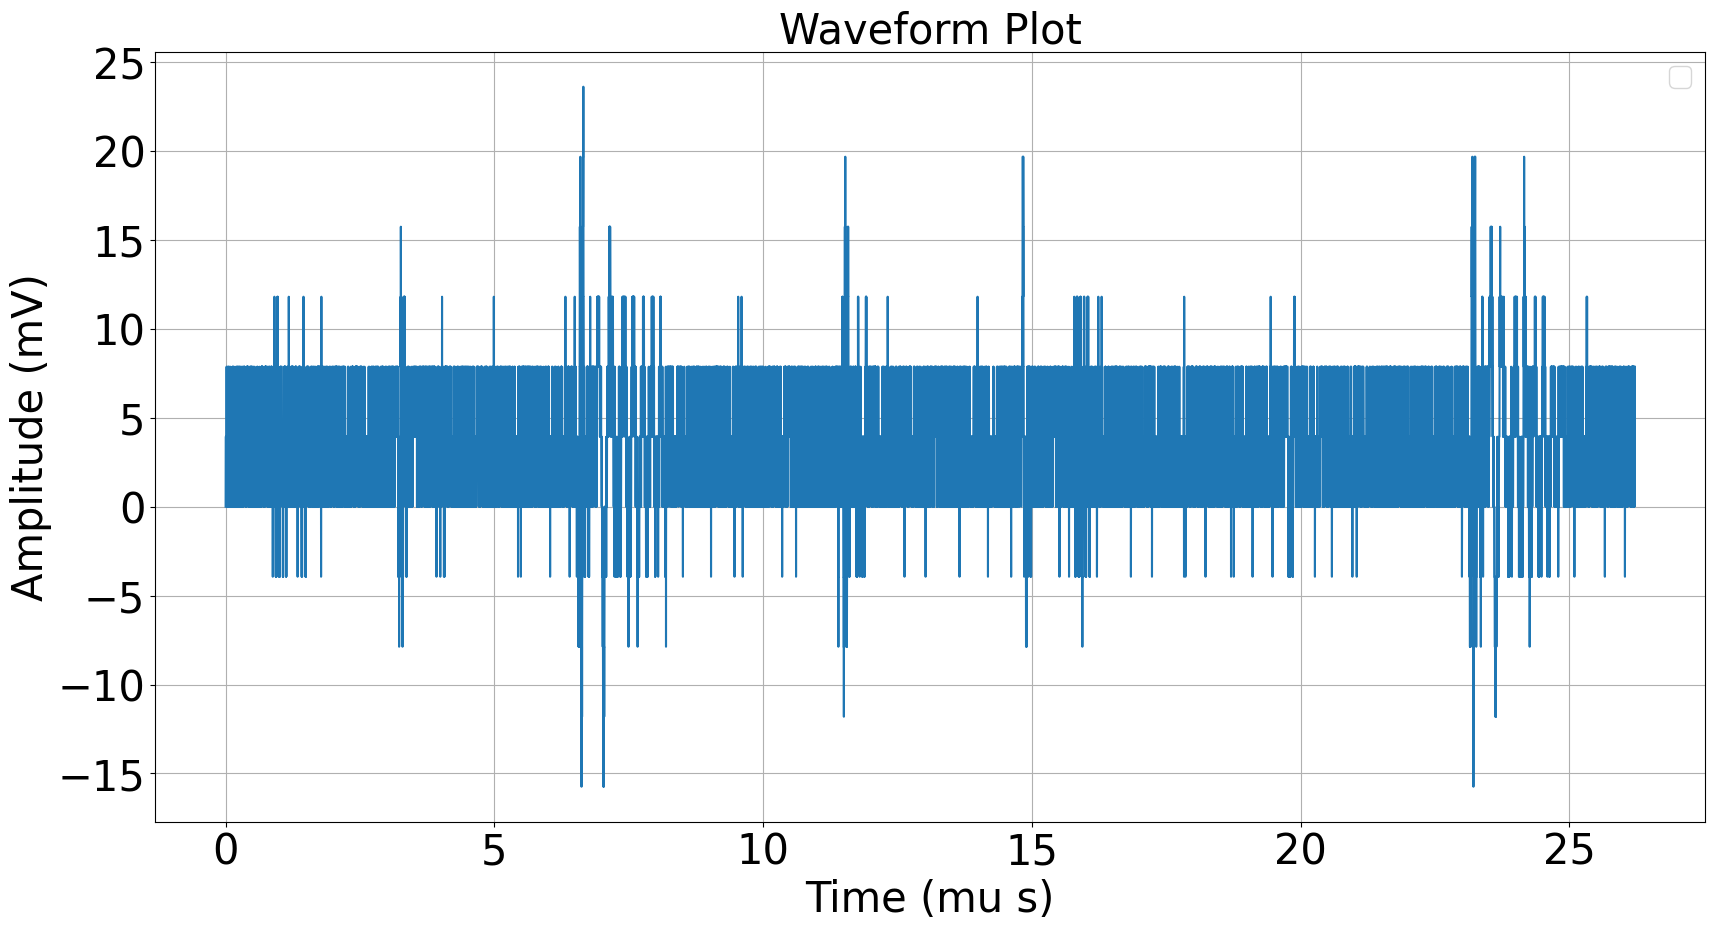

In [5]:
plt.figure(figsize=(20, 10))
#plt.errorbar(times_avg_wf, avg_wf, yerr=stds_wf, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1, label = f"{hour}_{day}")
plt.plot(times_avg_wf, avg_wf)
plt.title('Waveform Plot', fontsize = 30)
plt.xlabel('Time (mu s)', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Amplitude (mV)', fontsize = 30)
plt.yticks(fontsize = 30)
plt.legend(loc = "best",  prop={'size': 20})
plt.grid(True)
plt.show()

### compute and plot the phases of the average waveform

f_s_avg_wf = 1250.038131446526


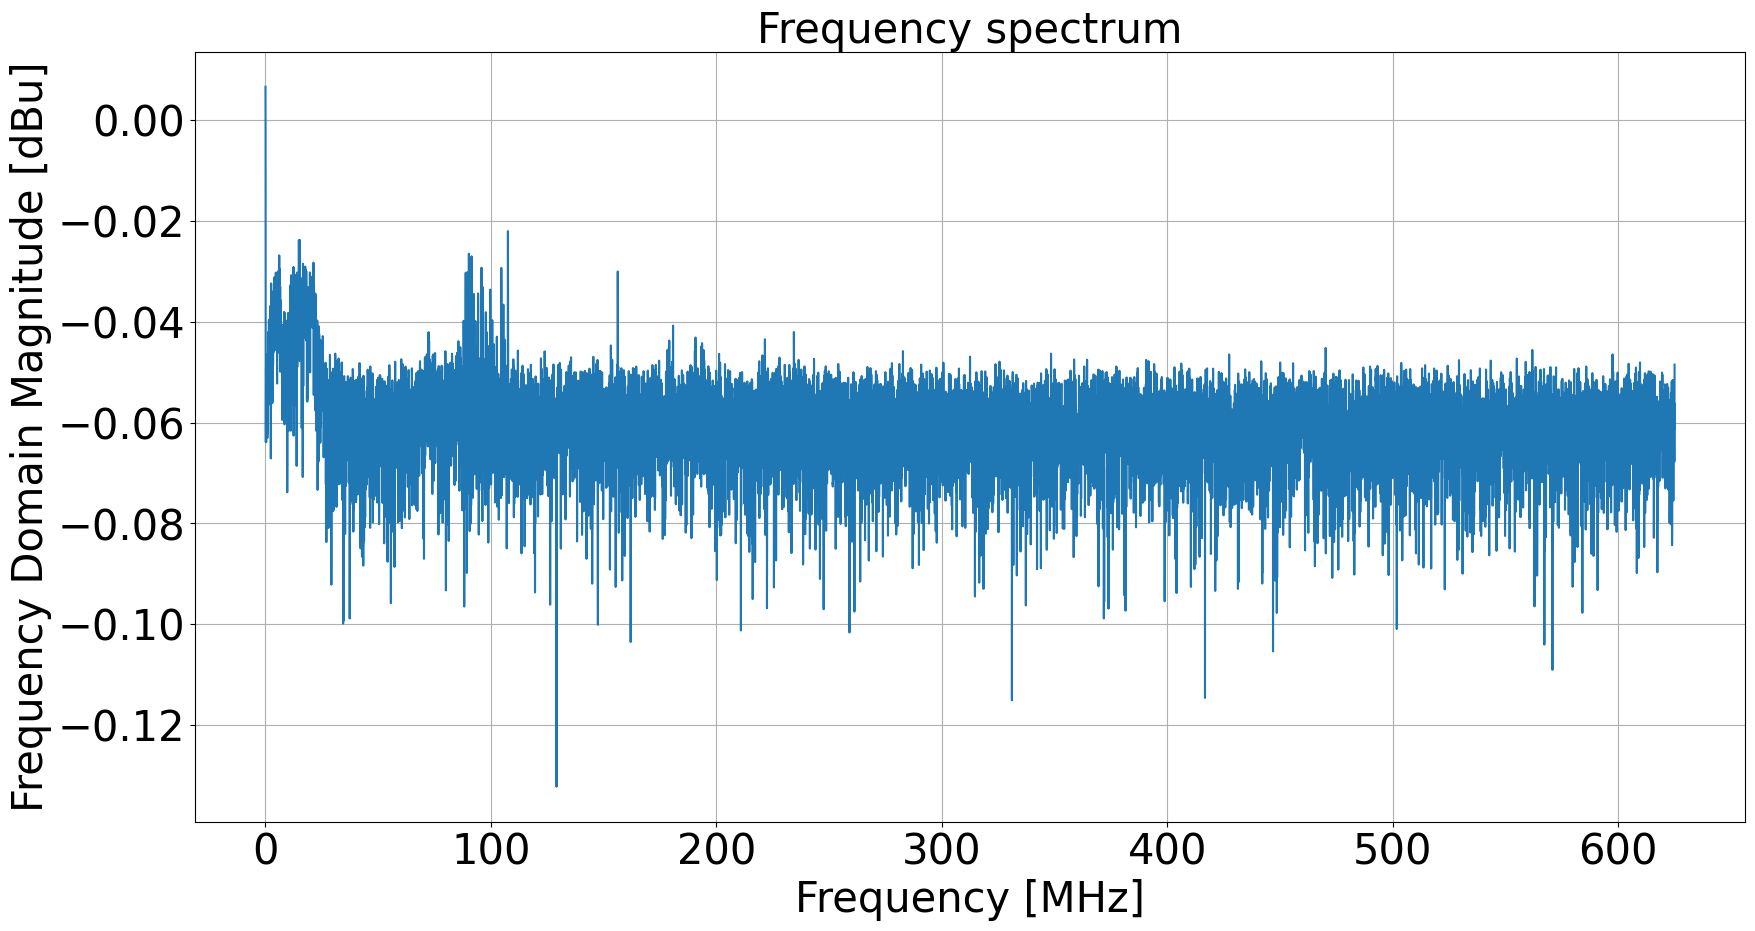

Execution time: 0.4309210777282715 seconds


In [6]:
span_avg_wf = times_avg_wf[len(times_avg_wf)-1] 
f_s_avg_wf = len(times_avg_wf) / span_avg_wf
print(f"f_s_avg_wf = {f_s_avg_wf}")
freqs_avg_wf = fft.rfftfreq(len(avg_wf), 1/f_s_avg_wf) #window lenght, sample spacing

#plot the fft and see how much time it takes
start_time = time.time()

Y_dBu, phases_avg_wf = rfft(avg_wf, conversion_factor)

plt.figure(figsize=(20, 10))
#plt.errorbar(freqs_avg_wf, Y_dBu, yerr = Y_err_dBu, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.plot(freqs_avg_wf, Y_dBu)
plt.title('Frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [dBu]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
#plt.semilogx()
plt.show()

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

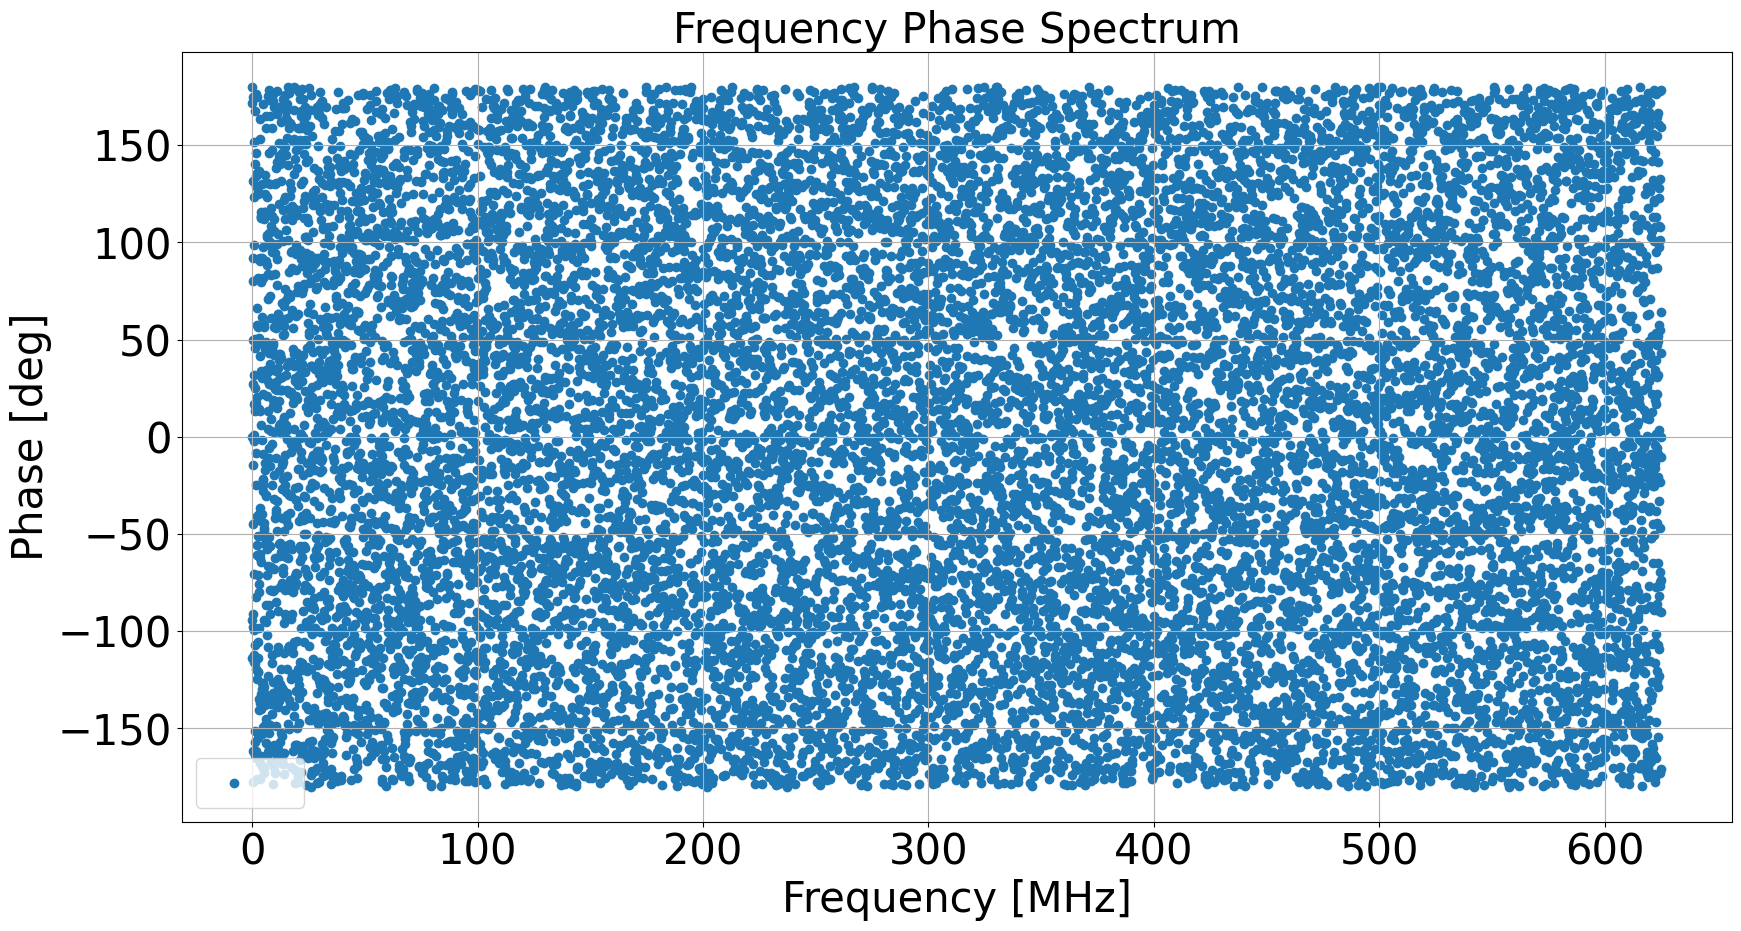

In [7]:
fig = plot_scatter_func(freqs_avg_wf, phases_avg_wf, ' ', 'Frequency Phase Spectrum', 'Frequency [MHz]', 'Phase [deg]')

plt.show()

# Phase of the average of the ffts

In [8]:
file_pattern_wfs = f"../Waveforms/{day}/{day}_{hour}/{day}_{hour}_wf.csv/{day}_{hour}_wf_*.csv"
file_list_wfs = glob.glob(file_pattern_wfs)

amplitudes_list_avg_ph = []

if not file_list:
    print("No files found for the given pattern.")
else:
    for i, file in enumerate(file_list):
        df = pd.read_csv(file)
        if i == 0:
            print(df.iloc[:, 0])
            print(df.iloc[:, 1])
            times_avg_ph = pd.to_numeric(df.iloc[1:, 0], errors = 'coerce').values
            amplitudes_avg_ph = pd.to_numeric(df.iloc[1:, 1], errors='coerce').values
        amplitudes_list_avg_ph.append(amplitudes_avg_ph)
        
all_amplitudes_avg_ph = np.stack(amplitudes_list_avg_ph, axis = 0)

0               (us)
1         0.00000000
2         0.00080000
3         0.00160000
4         0.00240000
            ...     
32764    26.21040035
32765    26.21120035
32766    26.21200035
32767    26.21280035
32768    26.21360035
Name: Time, Length: 32769, dtype: object
0              (mV)
1        0.00000000
2        3.93700800
3        0.00000000
4        3.93700800
            ...    
32764    3.93700800
32765    0.00000000
32766    3.93700800
32767    3.93700800
32768    7.87401500
Name: Channel A, Length: 32769, dtype: object


In [9]:
#The ADC of the Picoscope only represents discrete levels of input voltage in 8 bit resolution
conversion_factor = 0.001

### compute the FFTs

In [10]:
Ys = rffts(all_amplitudes_avg_ph)

### compute and plot the average fft and its phase

In [11]:
span_avg_ph = times_avg_ph[len(times_avg_ph)-1] 
f_s_avg_fft = len(times_avg_ph) / span_avg_ph
print(f"f_s_avg_fft = {f_s_avg_fft}")
freqs_avg_ph = fft.rfftfreq(all_amplitudes_avg_ph.shape[1], 1/f_s_avg_fft) #window lenght, sample spacing

avg_fft_dBu, avg_phases = mean_fft(Ys, conversion_factor)

f_s_avg_fft = 1250.038131446526


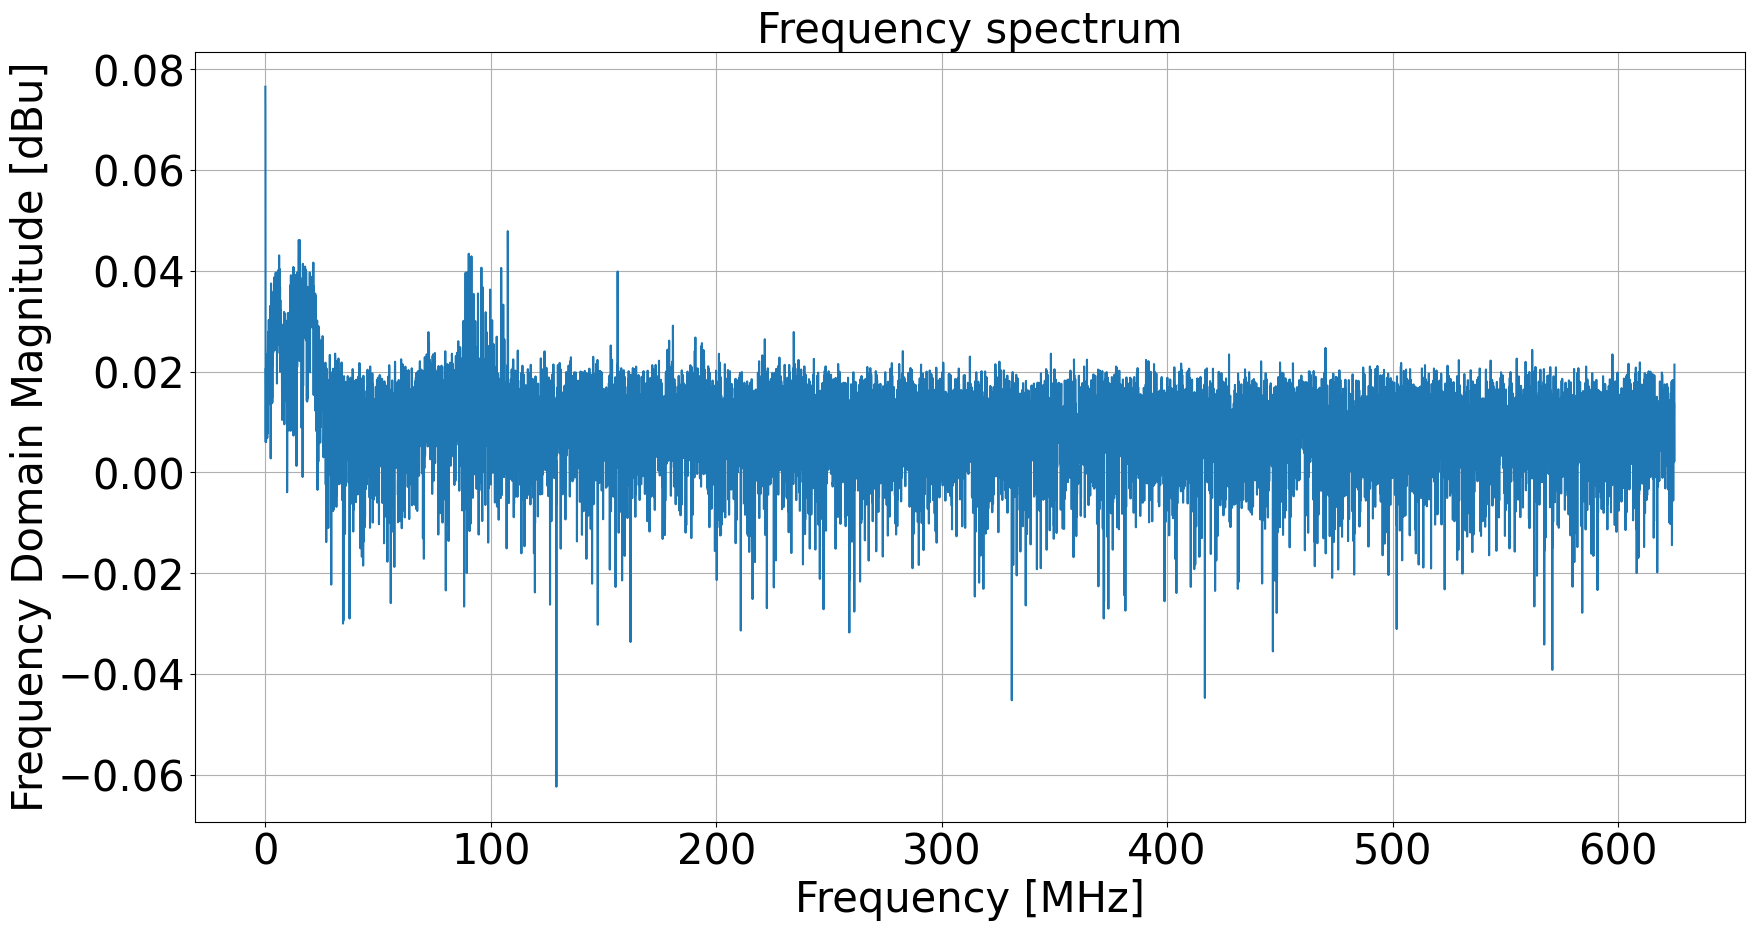

In [12]:
plt.figure(figsize=(20, 10))
#plt.errorbar(freqs_avg_ph, avg_fft_dBu, yerr = stds_fft_dBu, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.plot(freqs_avg_ph, avg_fft_dBu)
plt.title('Frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [dBu]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
#plt.semilogx()
plt.show()


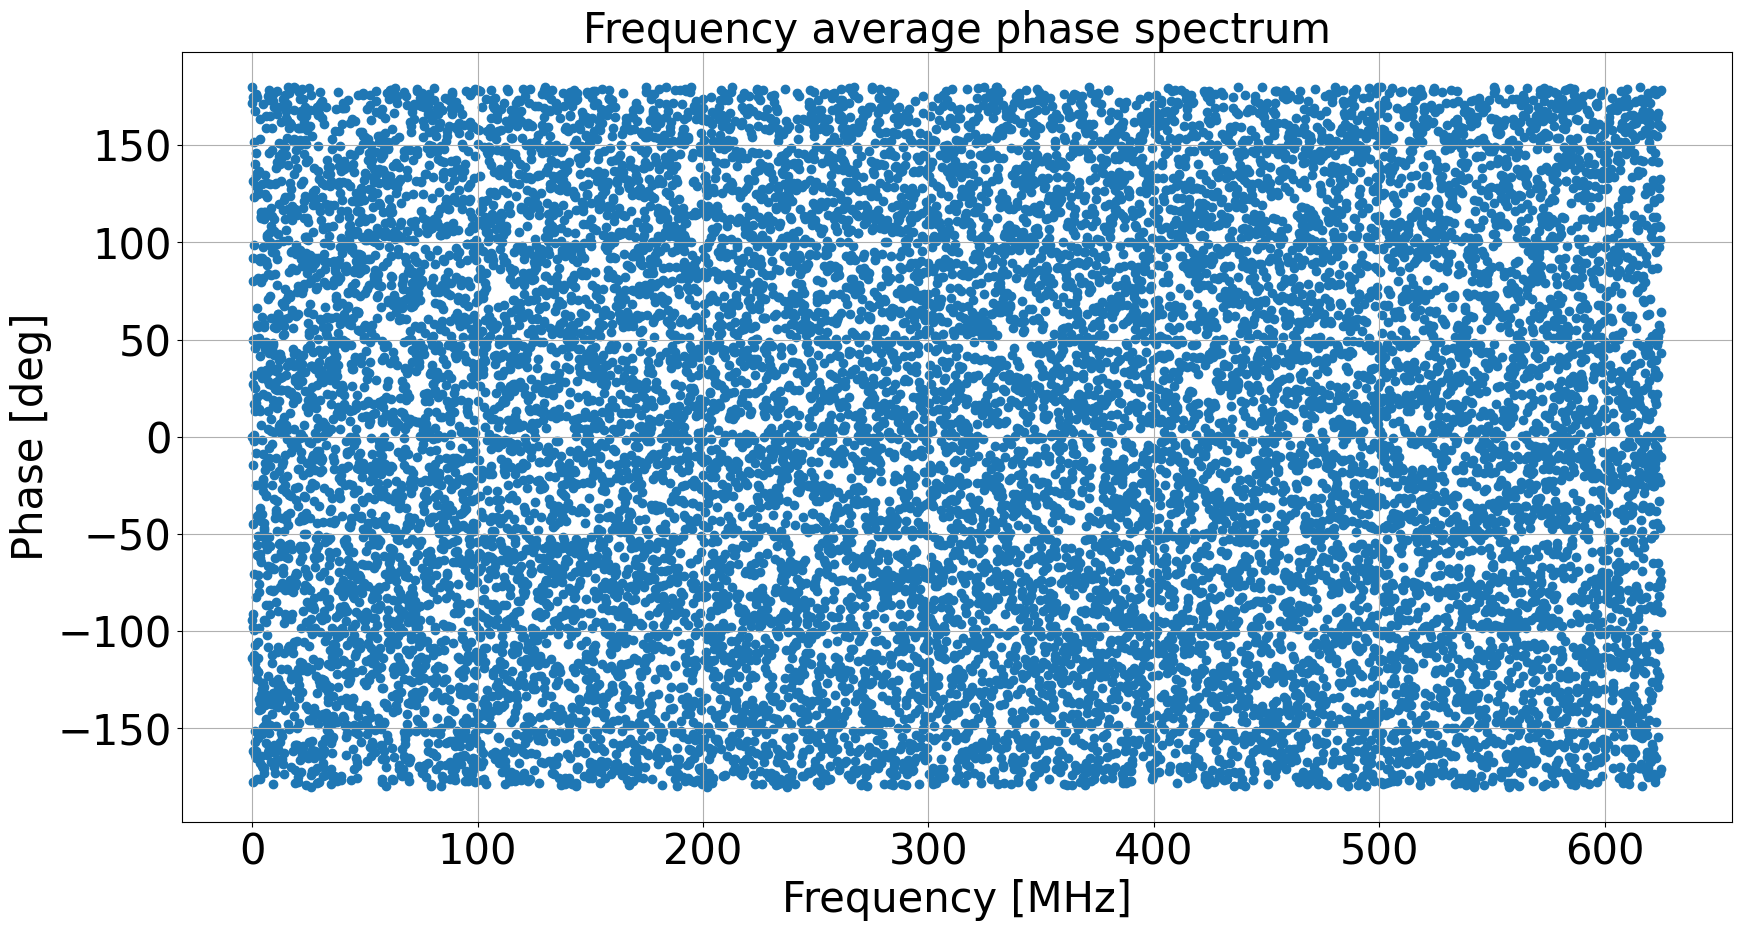

In [13]:
plt.figure(figsize=(20, 10))
#plt.errorbar(freqs_avg_ph, phases_avg, yerr = phases_err_avg, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.scatter(freqs_avg_ph, avg_phases)
plt.title('Frequency average phase spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Phase [deg]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
#plt.semilogx()

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()


# Comparison between the two

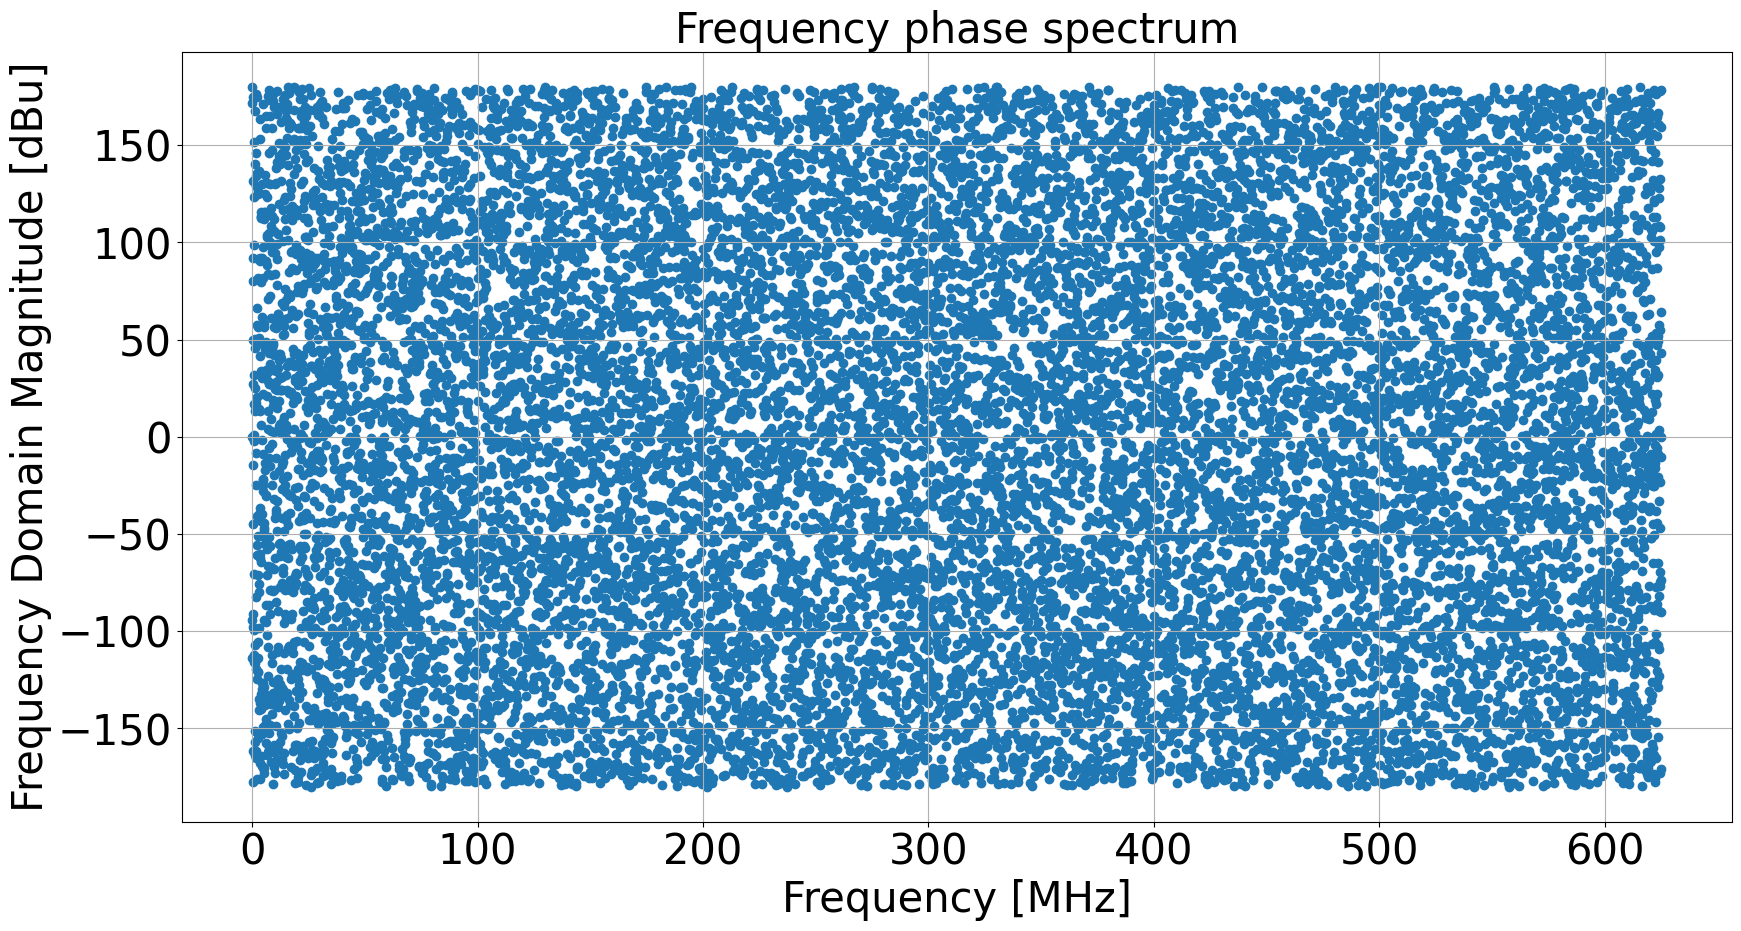

In [17]:
plt.figure(figsize=(20, 10))

#plt.errorbar(freqs, Y_dBu, yerr = Y_err_dBu, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.scatter(freqs_avg_wf, phases_avg_wf)
plt.title('Frequency phase spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [dBu]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
#plt.semilogx()

#---------------------------------------------------------------
#plt.errorbar(freqs, magnitudes_avg, yerr = errors, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.scatter(freqs_avg_ph, avg_phases)
plt.title('Frequency phase spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [dBu]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
#plt.semilogx()

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()